Hello Edgardo!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure!

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text here.
</div>


# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Check dataset structure and missing values
df_reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

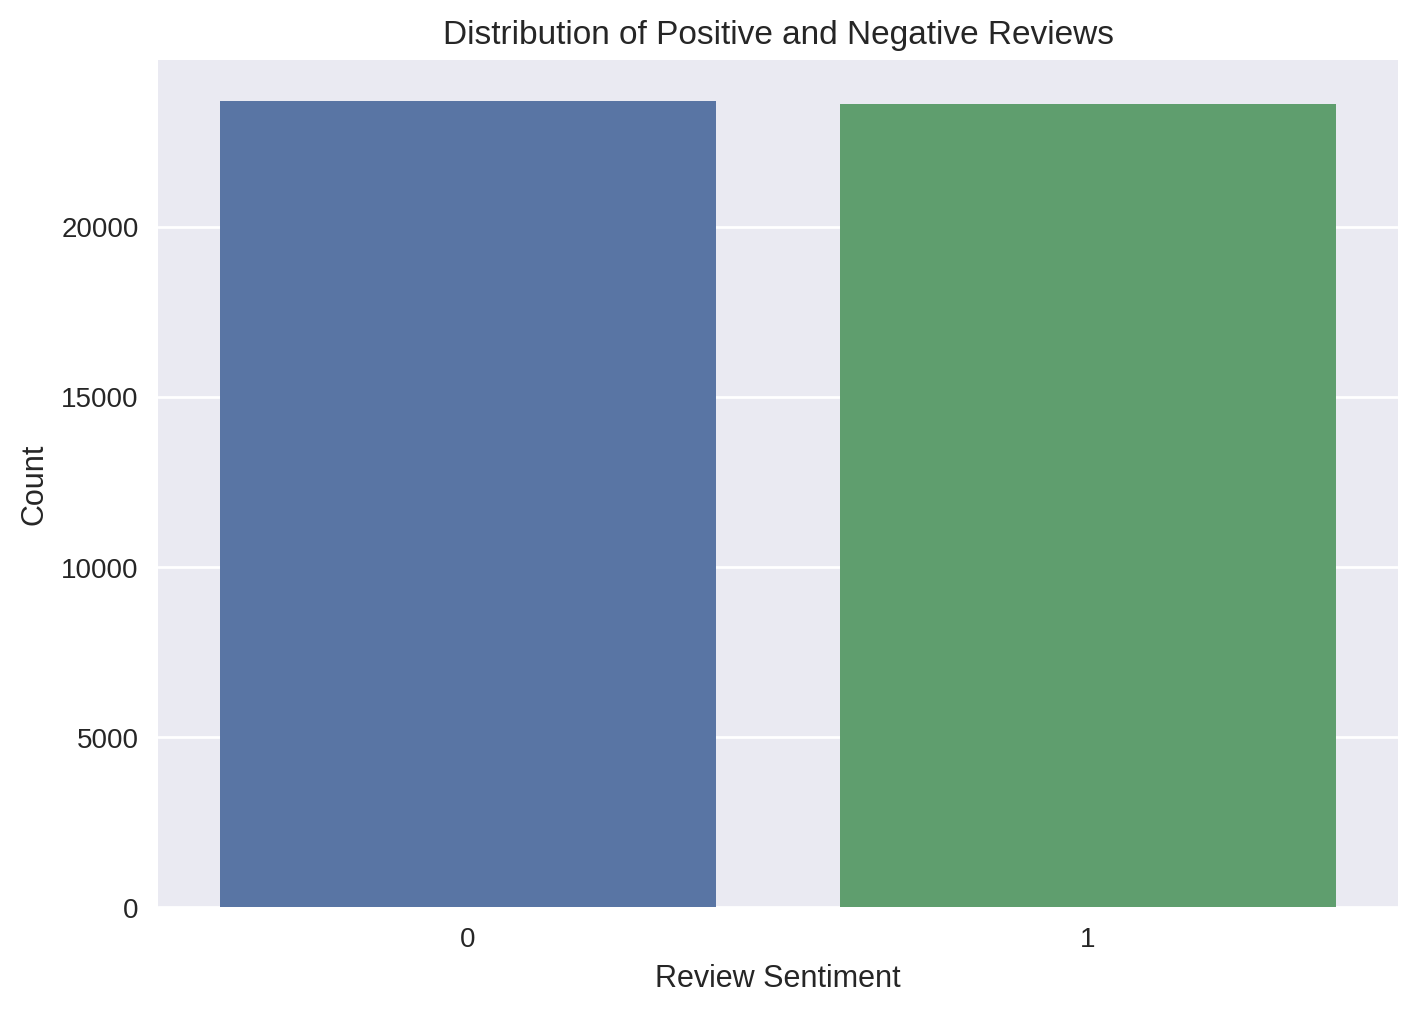

0    0.501046
1    0.498954
Name: pos, dtype: float64

In [6]:
# Check the distribution of positive (1) and negative (0) reviews
sns.countplot(x='pos', data=df_reviews)
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.show()

df_reviews['pos'].value_counts(normalize=True)


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

## EDA

Let's check the number of movies and reviews over years.

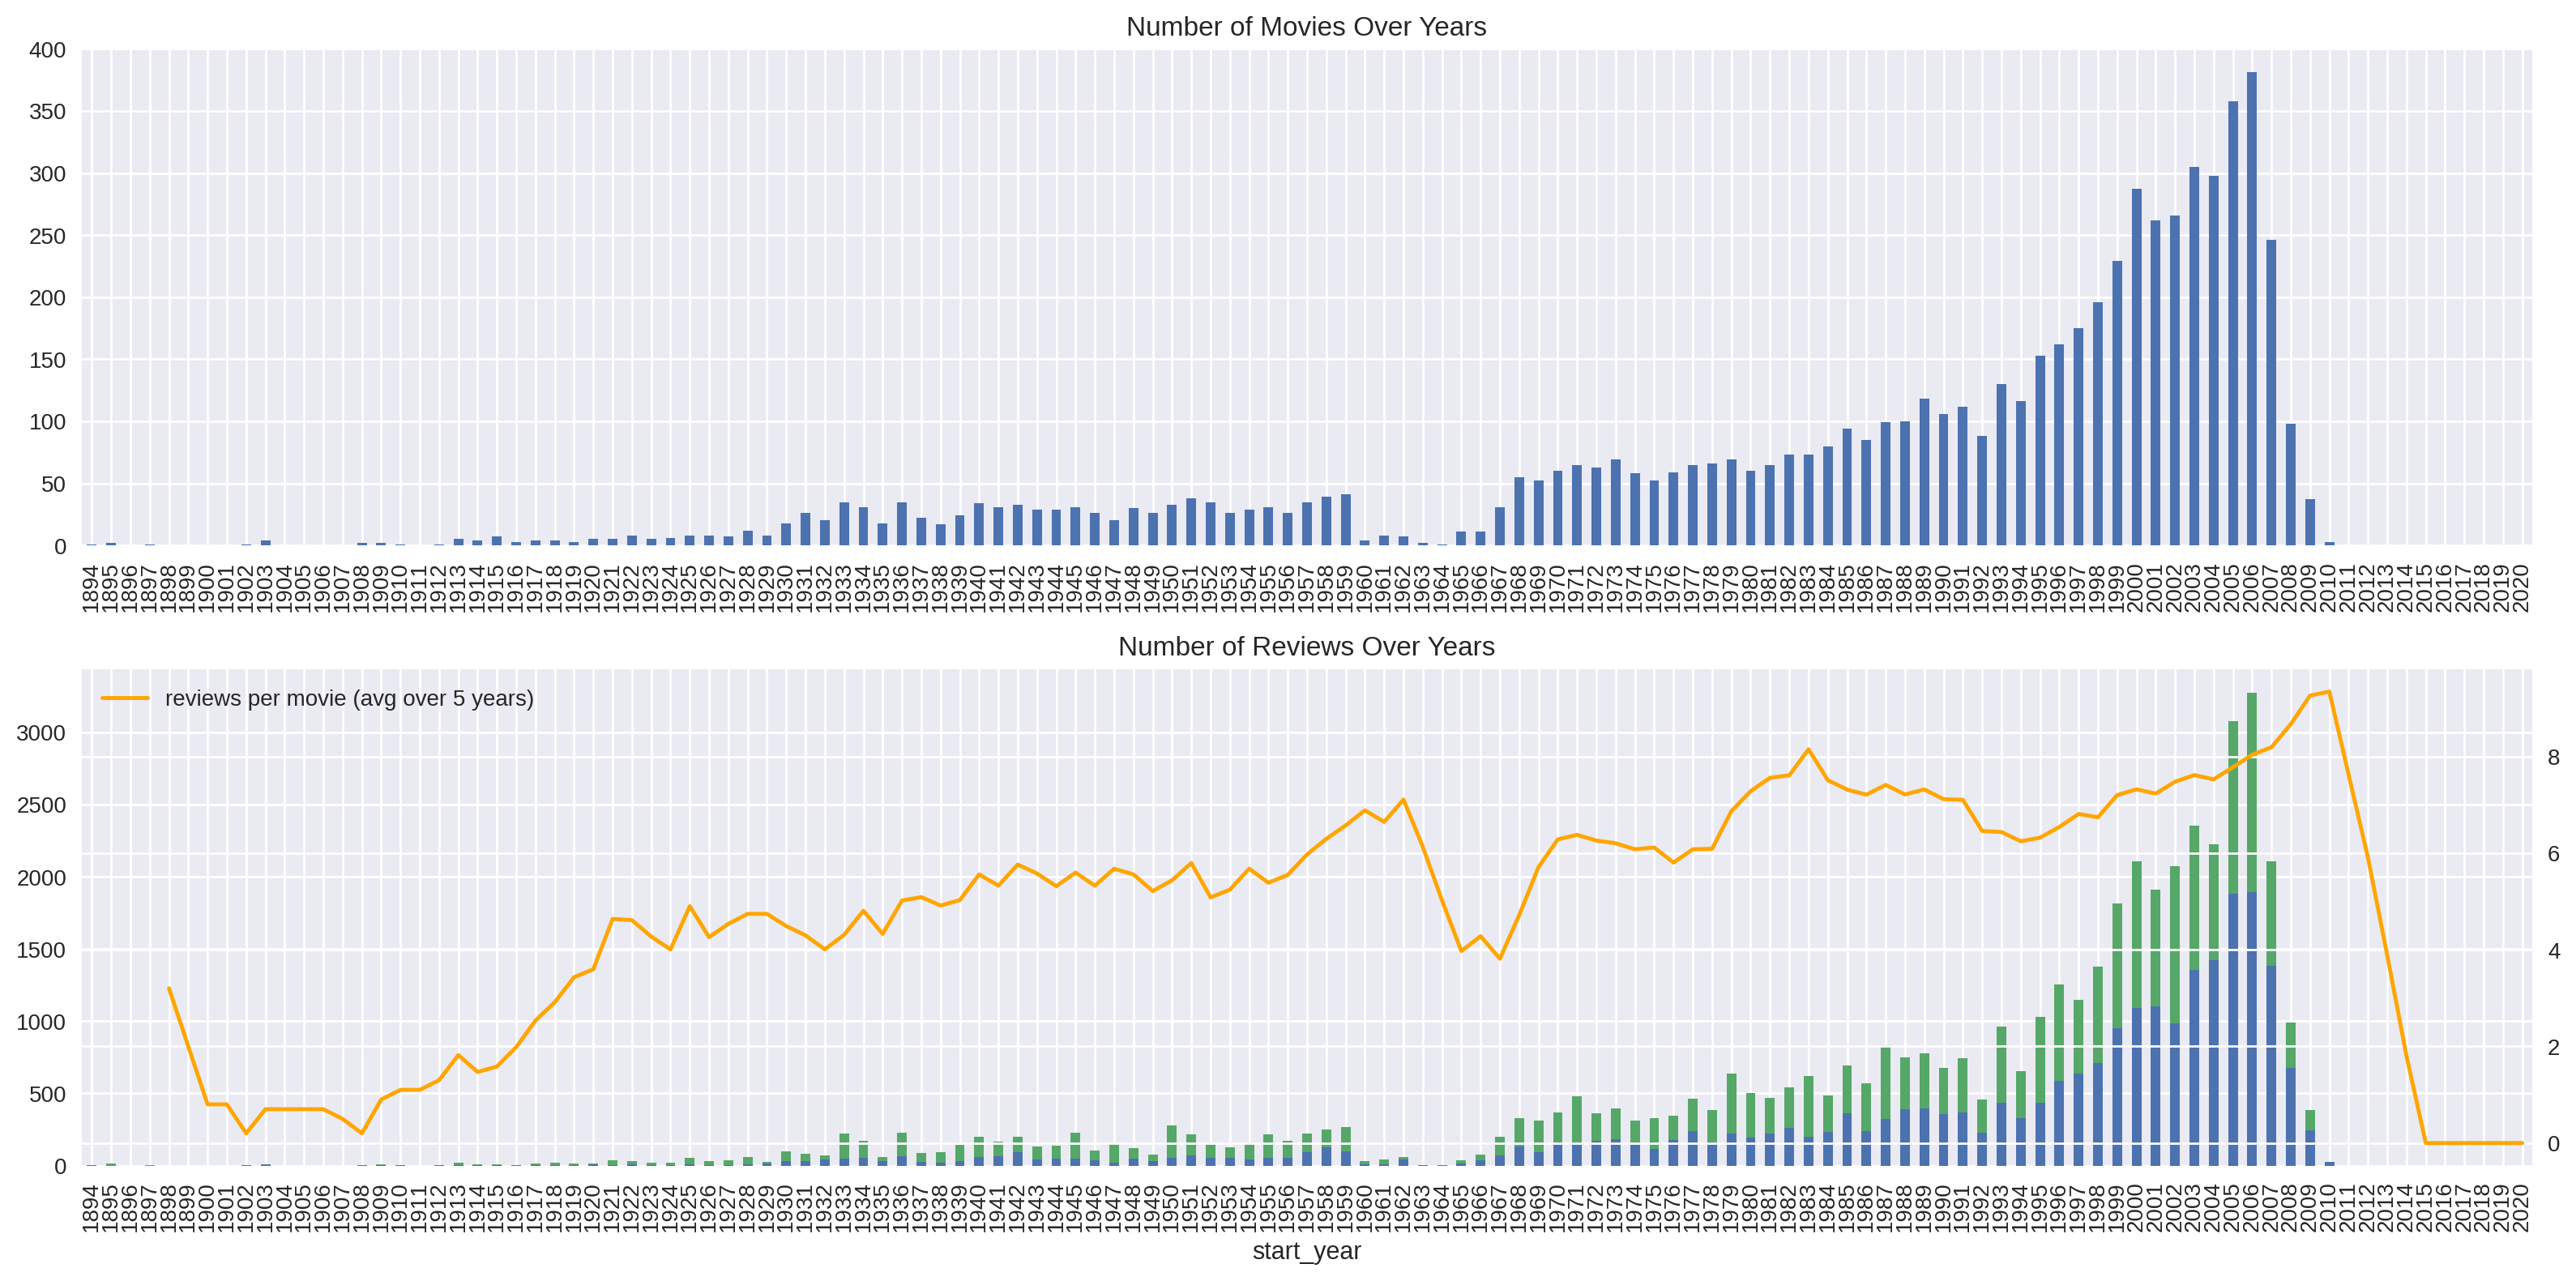

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

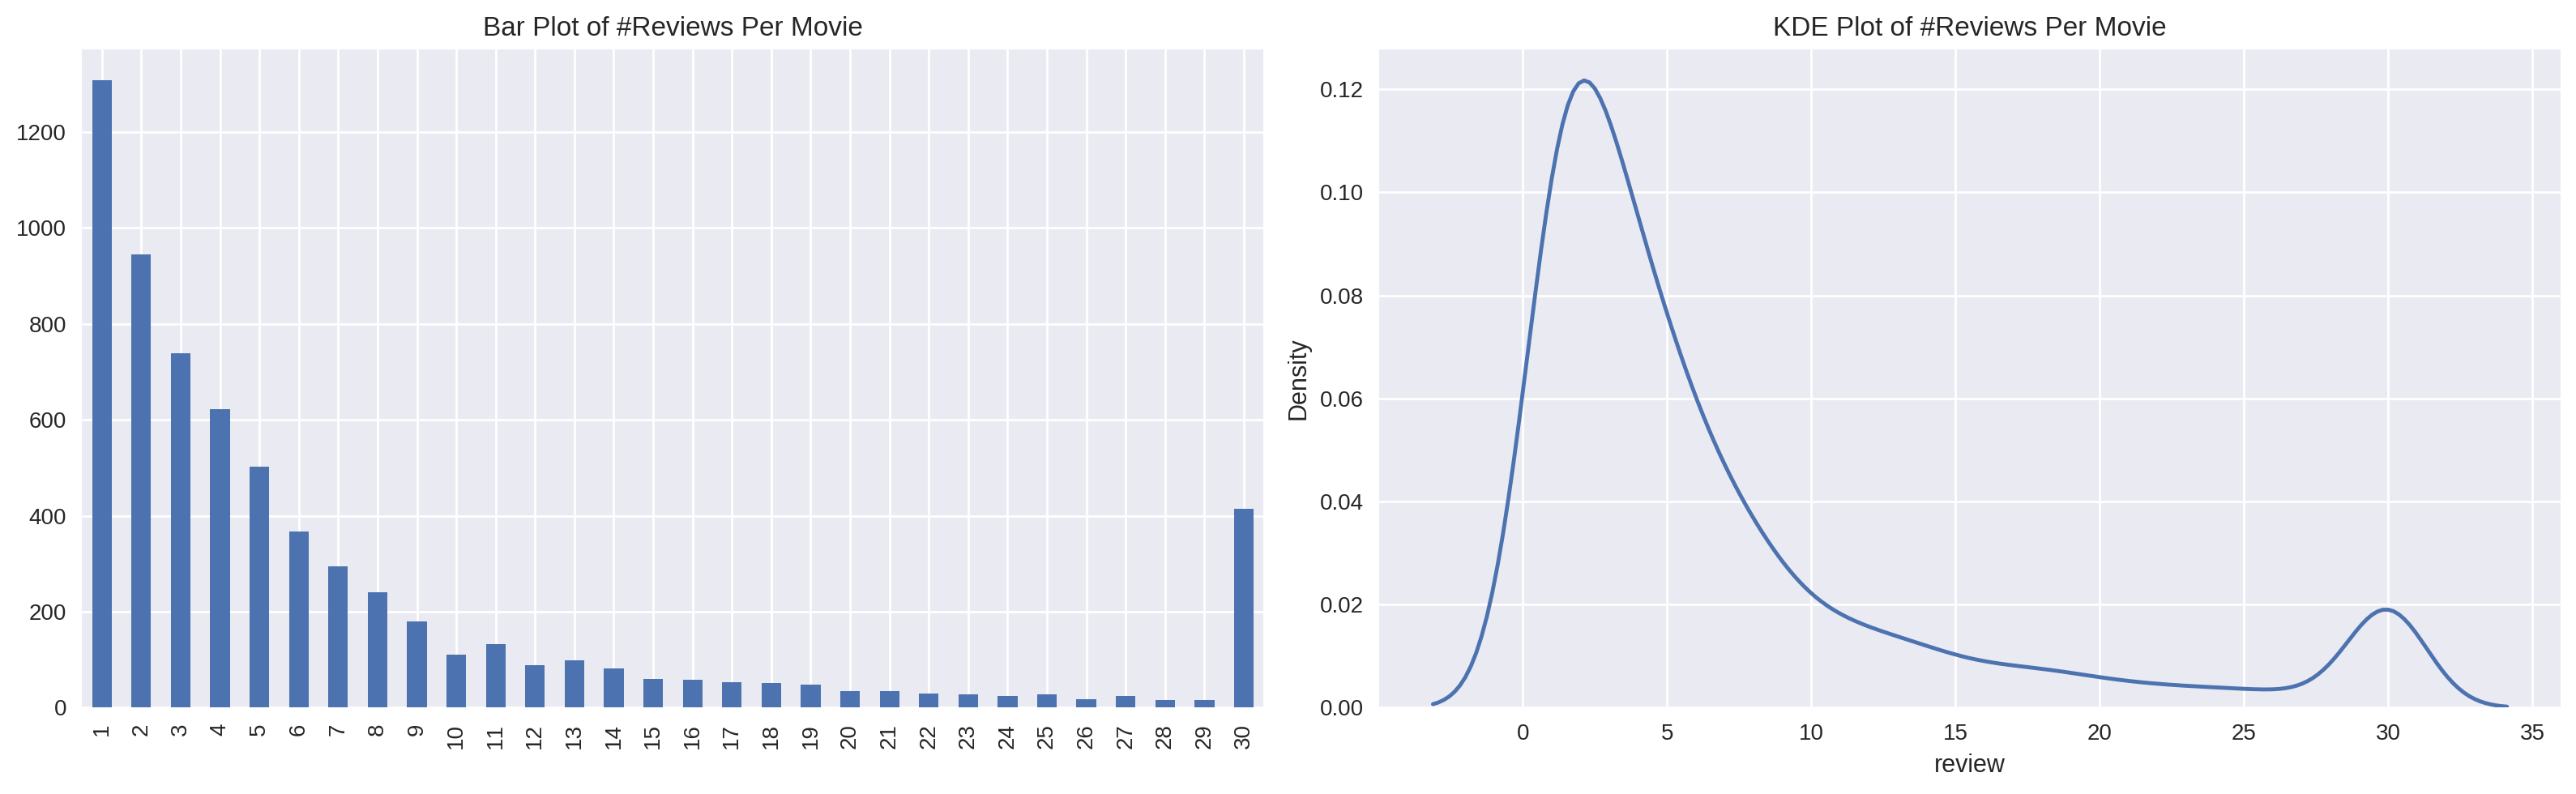

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

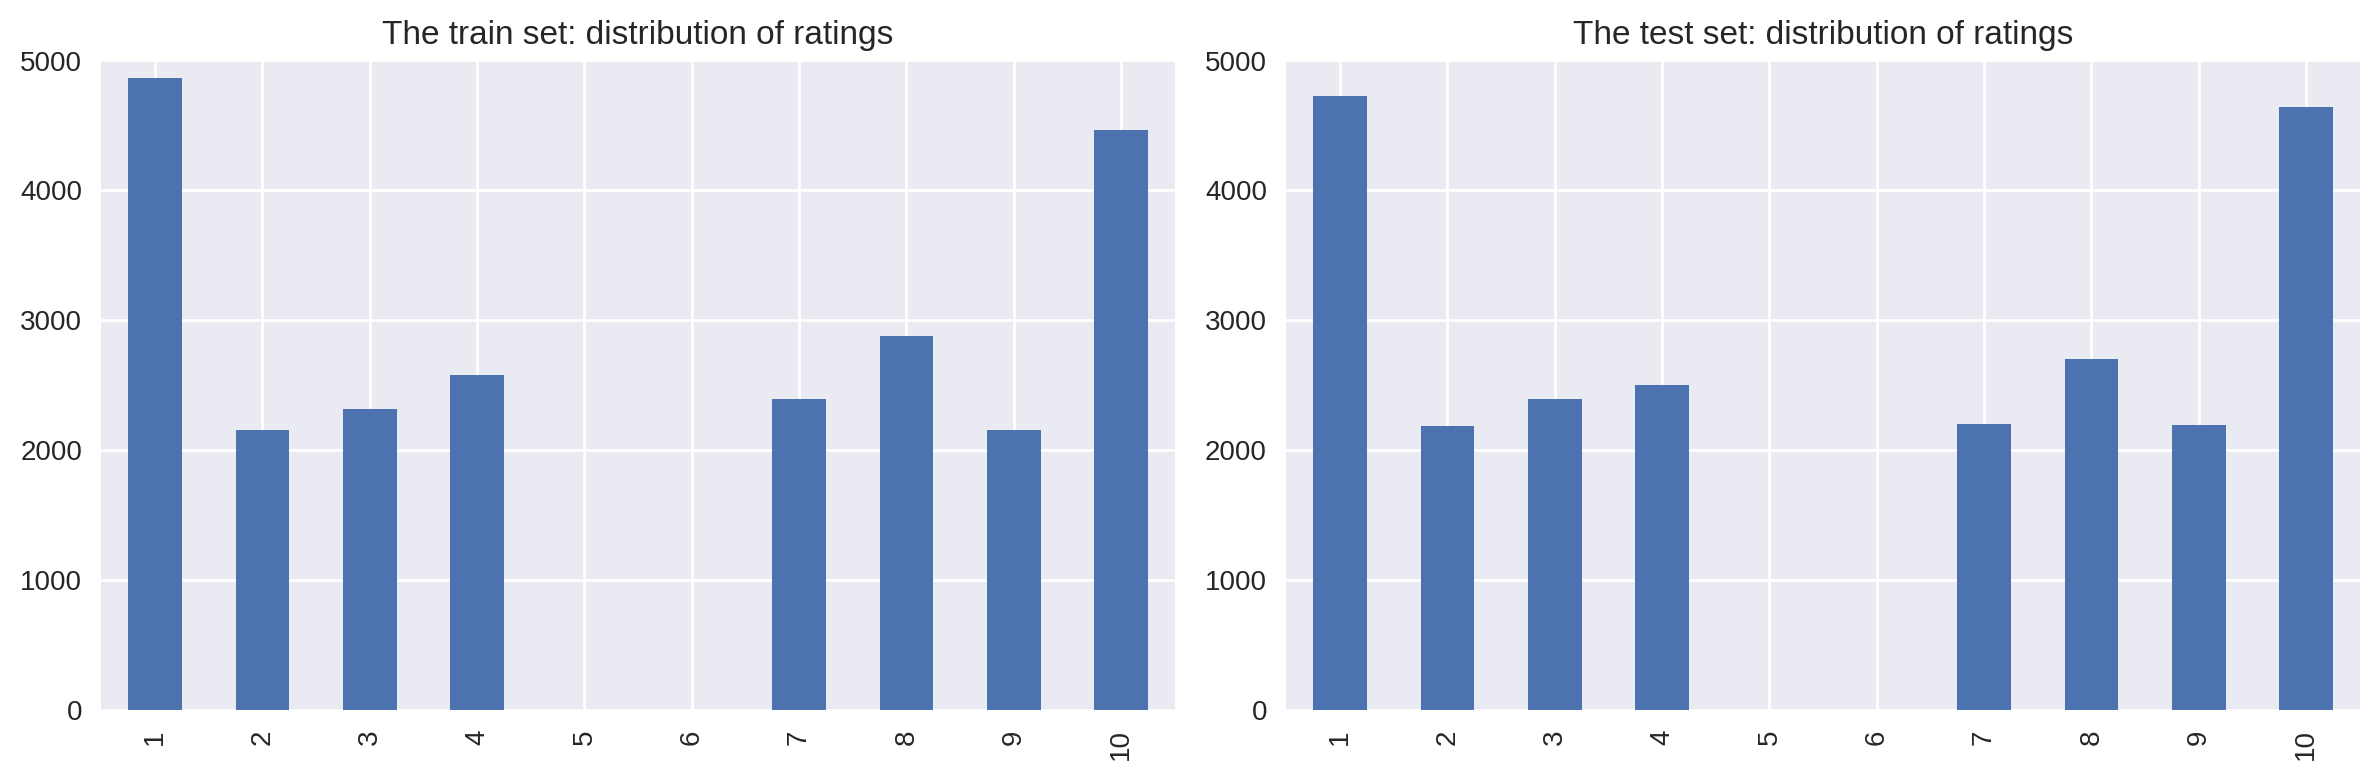

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


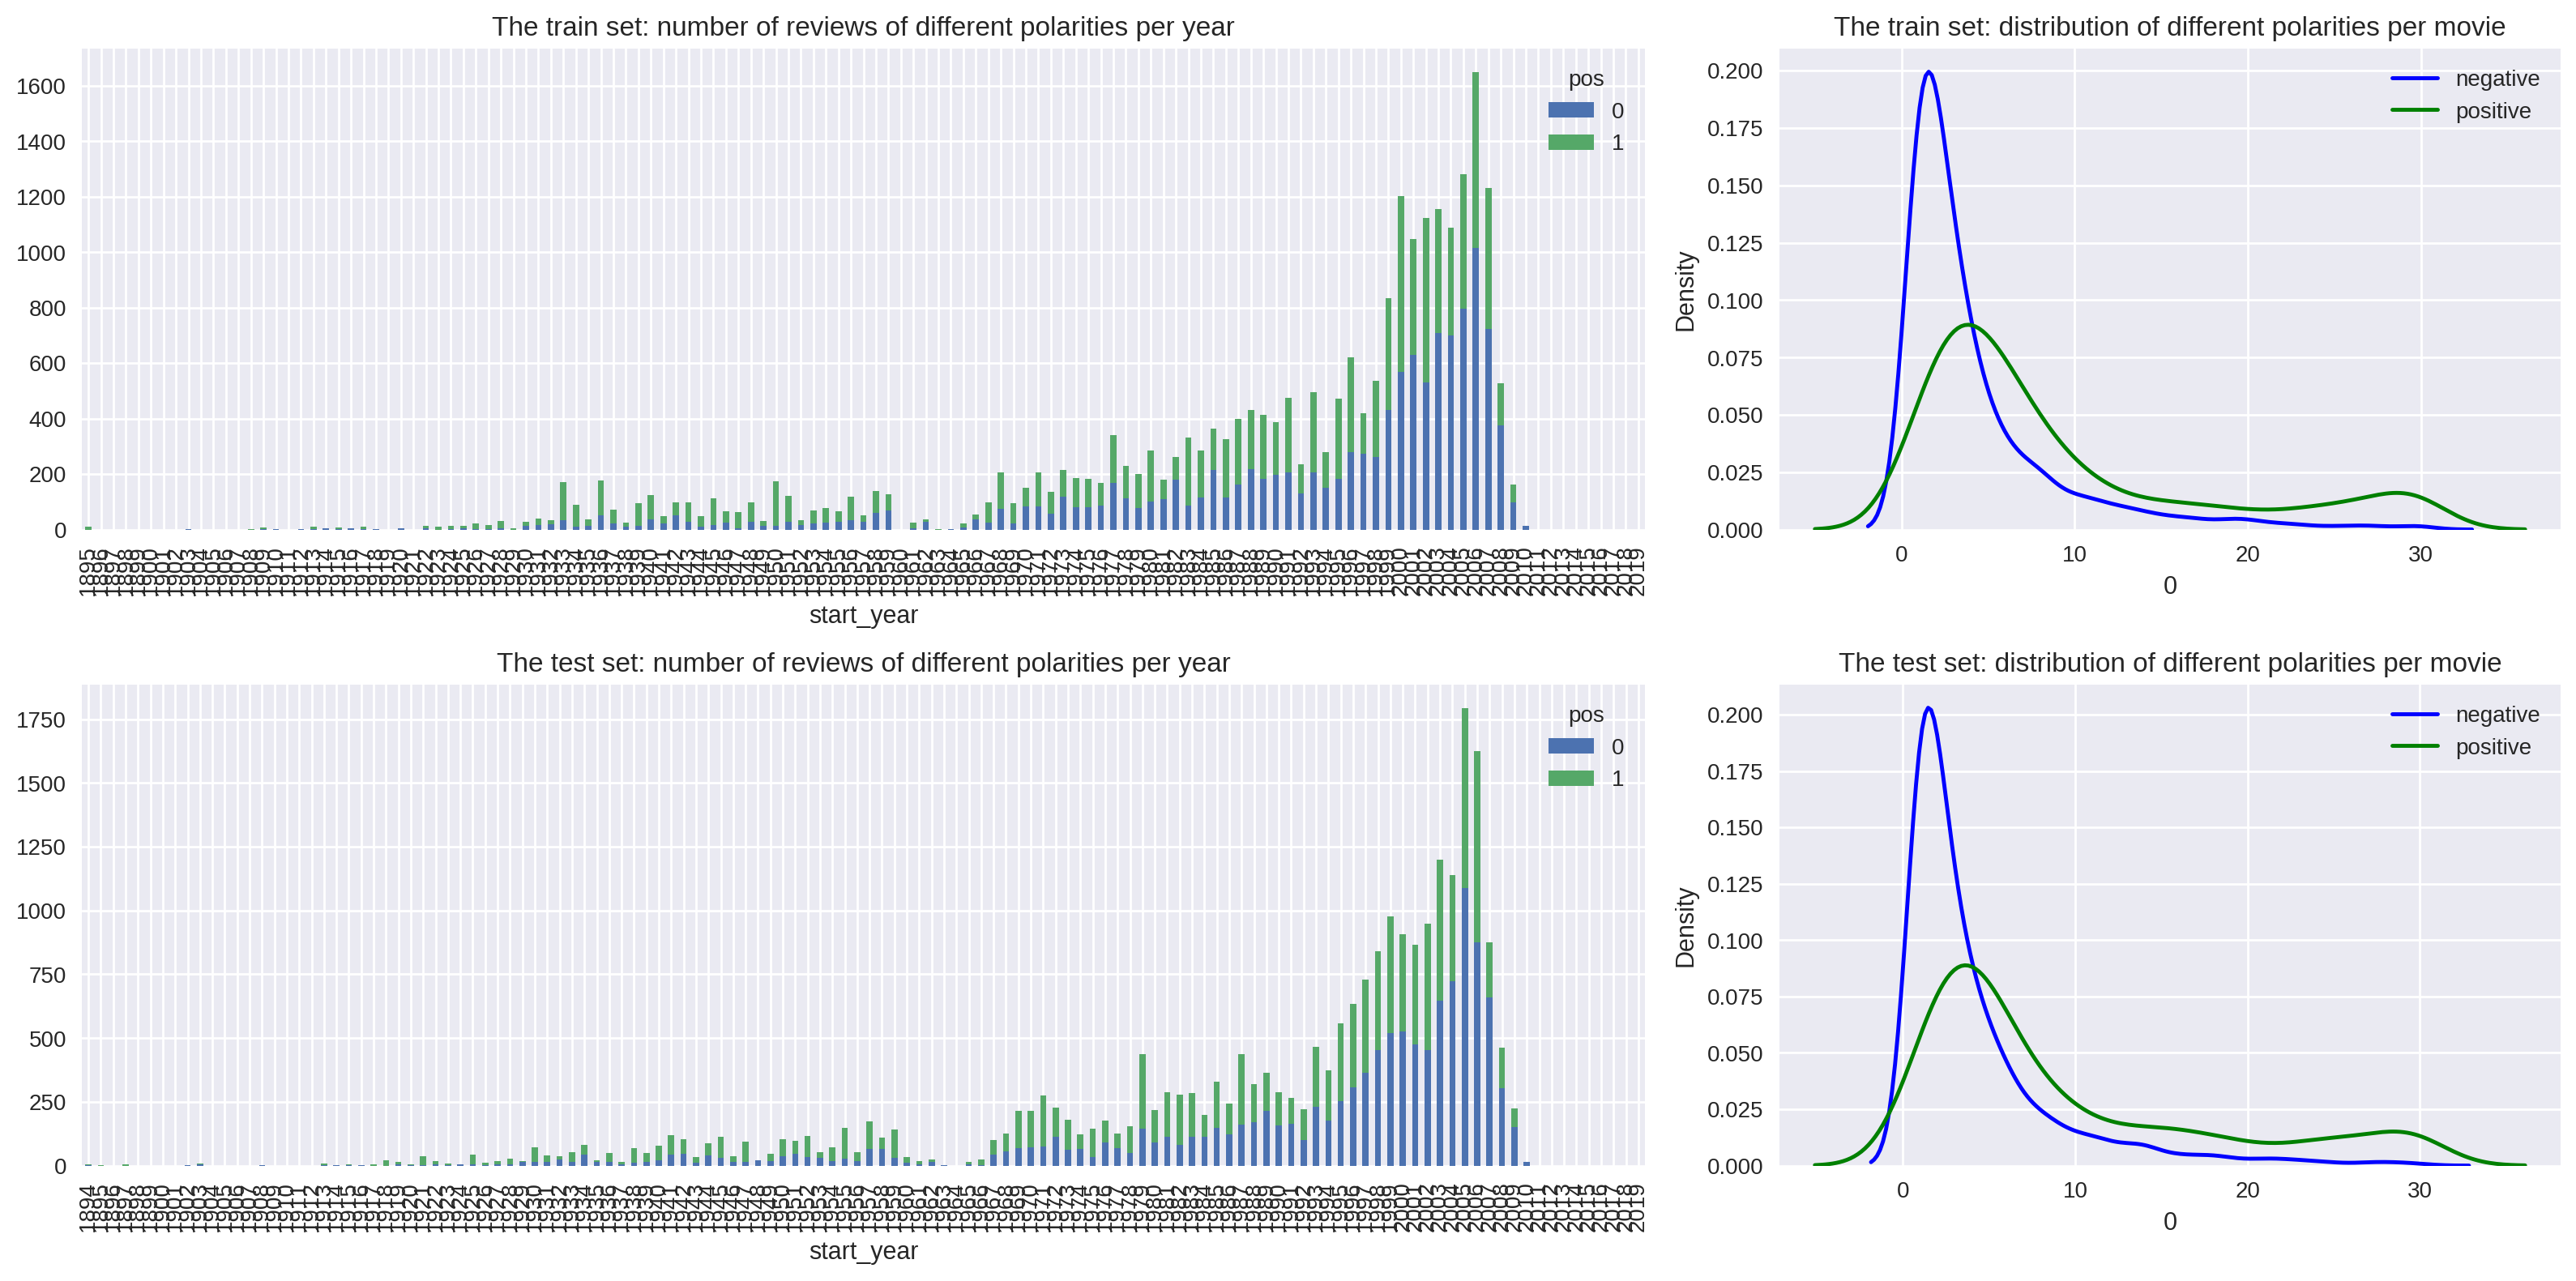

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

Even though the graphs have already been plotted, you need to analyze them and write conclusions.

</div>

The exploratory data analysis revealed several key insights about the IMDB review dataset. Over the years, the number of movies and reviews has steadily increased, with a notable rise after the 1980s and a sharp spike in reviews during the 2000s. When normalized, the average number of reviews per movie also showed an upward trend, reflecting growing audience engagement. The review distribution across movies follows a long-tail pattern, where most films receive only a few reviews, while a small number attract substantial attention. The sentiment classes are nearly perfectly balanced, with positive and negative reviews each making up roughly 50% of the dataset—ideal for training classification models. The ratings tend to cluster around the middle range (5 to 8 out of 10), and both positive and negative sentiments are consistently present across different years. Additionally, while many movies receive a mix of sentiments, some show strong polarity, either predominantly positive or negative. These findings confirm that the dataset is well-structured and suitable for training and evaluating sentiment classification models.

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Added conclusion to this section.
</div>


<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Good job!

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove digits and punctuation (keep only letters and spaces)
    text = re.sub(r"[^a-z\s]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply normalization to all reviews
df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

# Check the first few rows to confirm
print(df_reviews[['review', 'review_norm']].head())


                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                         review_norm  
0  the pakage implies that warren beatty and gold...  
1  how the hell did they get this made presenting...  
2  there is no real story the film seems more lik...  
3  um a serious film about troubled teens in sing...  
4  im totally agree with garryjohal from singapor...  


<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

At this step you don't need to make lemmatization. You have a task for it below. Here you need to normalize texts only: "We assume all models below accepts texts in __lowercase and without any digits, punctuations marks etc.__". So, please, remove lemmatization and leave only normalization.

</div>

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

The text data was normalized by converting all characters to lowercase, removing digits and punctuation, and retaining only alphabetic characters and spaces. Extra whitespace was also removed to prepare the text for further processing.
</div>


<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Well done!

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [15]:
from sklearn.dummy import DummyClassifier

In [16]:
# Initialize a baseline model that always predicts the most frequent class
dummy_model = DummyClassifier(strategy="most_frequent", random_state=42)

In [17]:
# Train the model
dummy_model.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(random_state=42, strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


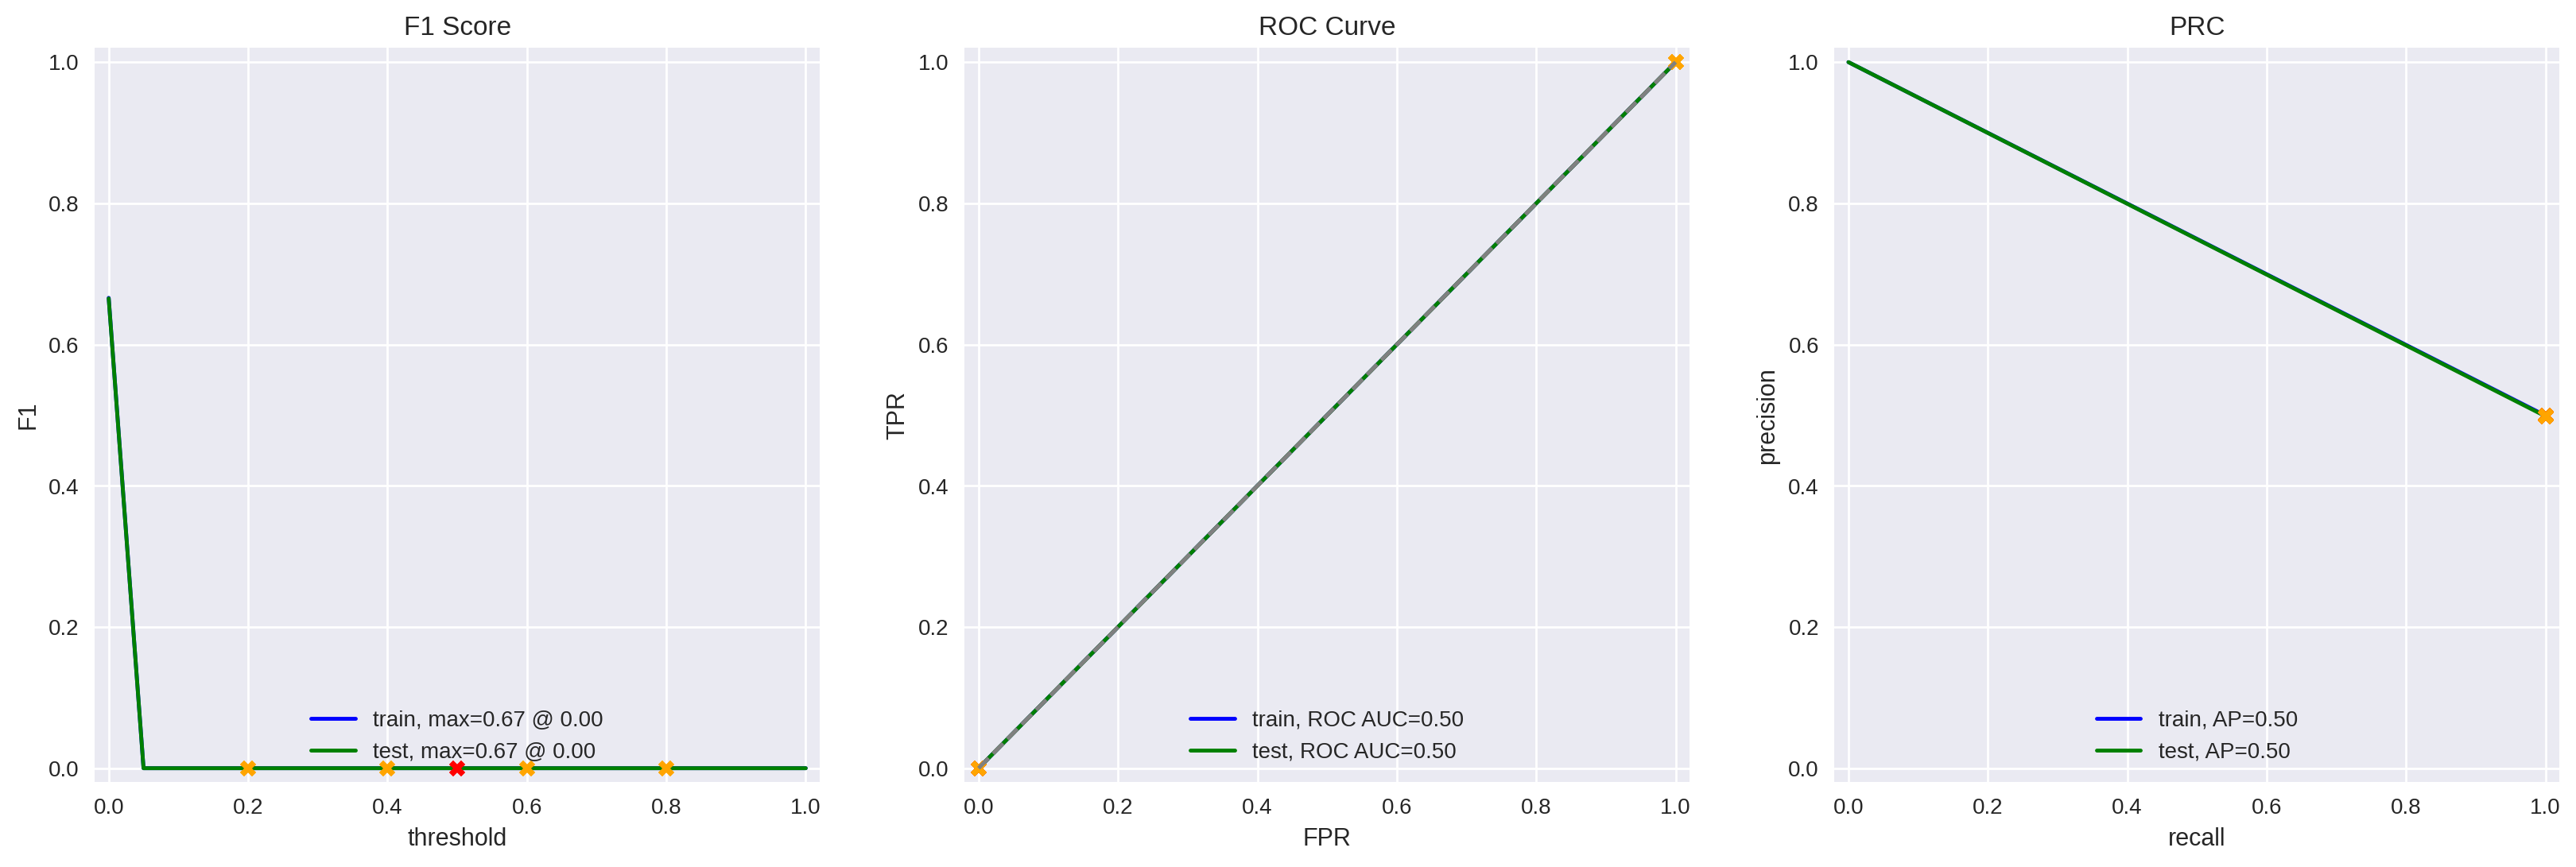

In [18]:
# Evaluate the model
evaluate_model(dummy_model, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

The Constant Model (Model 0) serves as a simple baseline by always predicting the most frequent class in the dataset without analyzing the text. This provides a point of reference to assess the effectiveness of more sophisticated models.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [20]:
# Define stop words
stop_words = set(stopwords.words('english'))


In [21]:
# Initialize the TF-IDF vectorizer with stop words and a limited feature set
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words, max_features=5000)


In [22]:
# Transform train and test reviews into TF-IDF features
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

# Display the shape of transformed data
print(f"Train TF-IDF Shape: {train_features_1.shape}")
print(f"Test TF-IDF Shape: {test_features_1.shape}")


Train TF-IDF Shape: (23796, 5000)
Test TF-IDF Shape: (23535, 5000)


In [23]:
# Initialize Logistic Regression model
model_1 = LogisticRegression(max_iter=500)

# Train the model on the TF-IDF features
model_1.fit(train_features_1, train_target)


LogisticRegression(max_iter=500)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


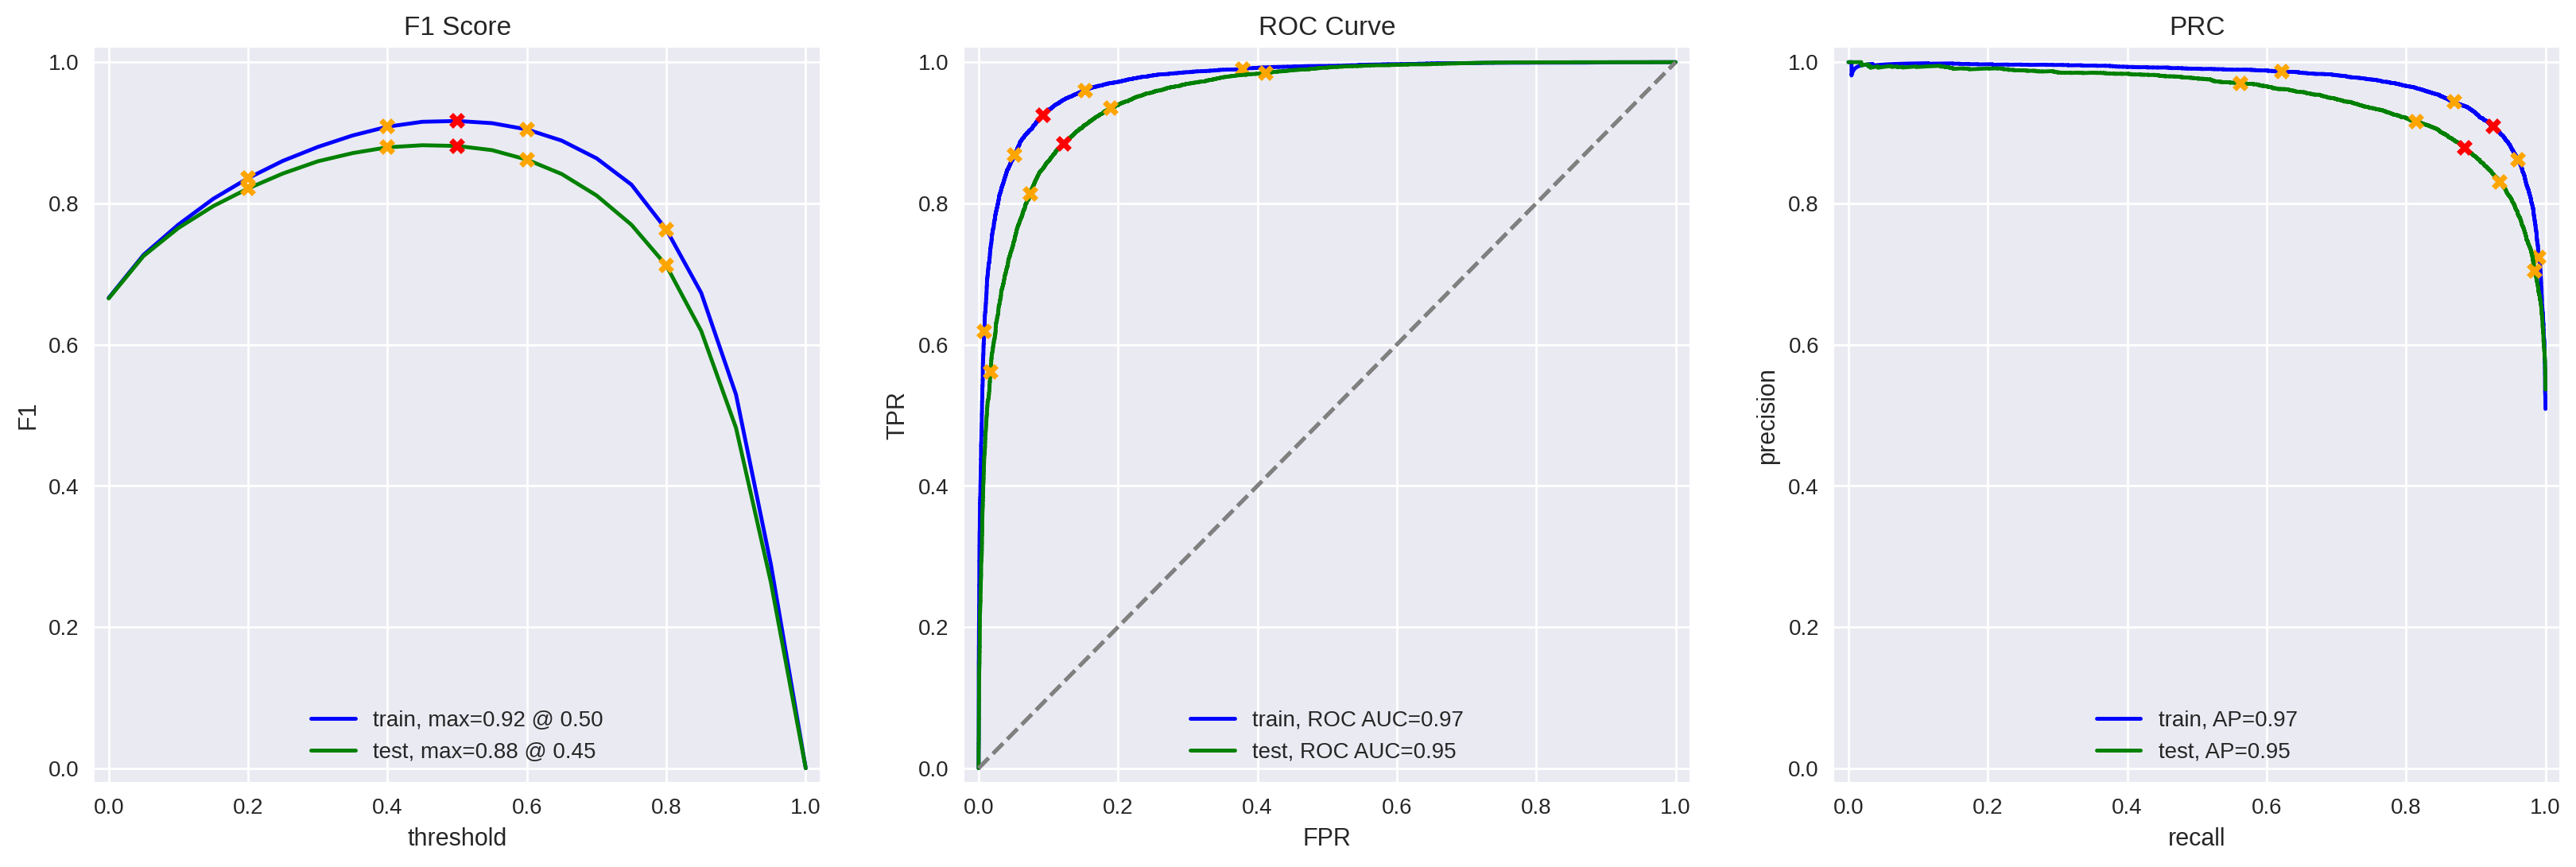

In [24]:
# Evaluate the model using the defined evaluation function
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)


The NLTK, TF-IDF, and Logistic Regression Model (Model 1) preprocesses the text using the Natural Language Toolkit (NLTK), removing stopwords and standardizing the text. It then applies Term Frequency-Inverse Document Frequency (TF-IDF) vectorization to transform the text into numerical features before training a Logistic Regression classifier to distinguish between positive and negative reviews.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Good job!

</div>

### Model 3 - spaCy, TF-IDF and LR

In [25]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [27]:
# Apply the function to the dataset
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Display the first few processed reviews
df_reviews_train[['review_norm', 'review_spacy']].head()

,review_norm,review_spacy
0,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...
1,how the hell did they get this made presenting...,how the hell do they get this make present its...
7,this true story of carlsons raiders is more of...,this true story of carlson raider be more of a...
8,should have been titled balderdash little in t...,should have be title balderdash little in the ...
9,the movie gung ho the story of carlsons makin ...,the movie gung ho the story of carlson makin i...


          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


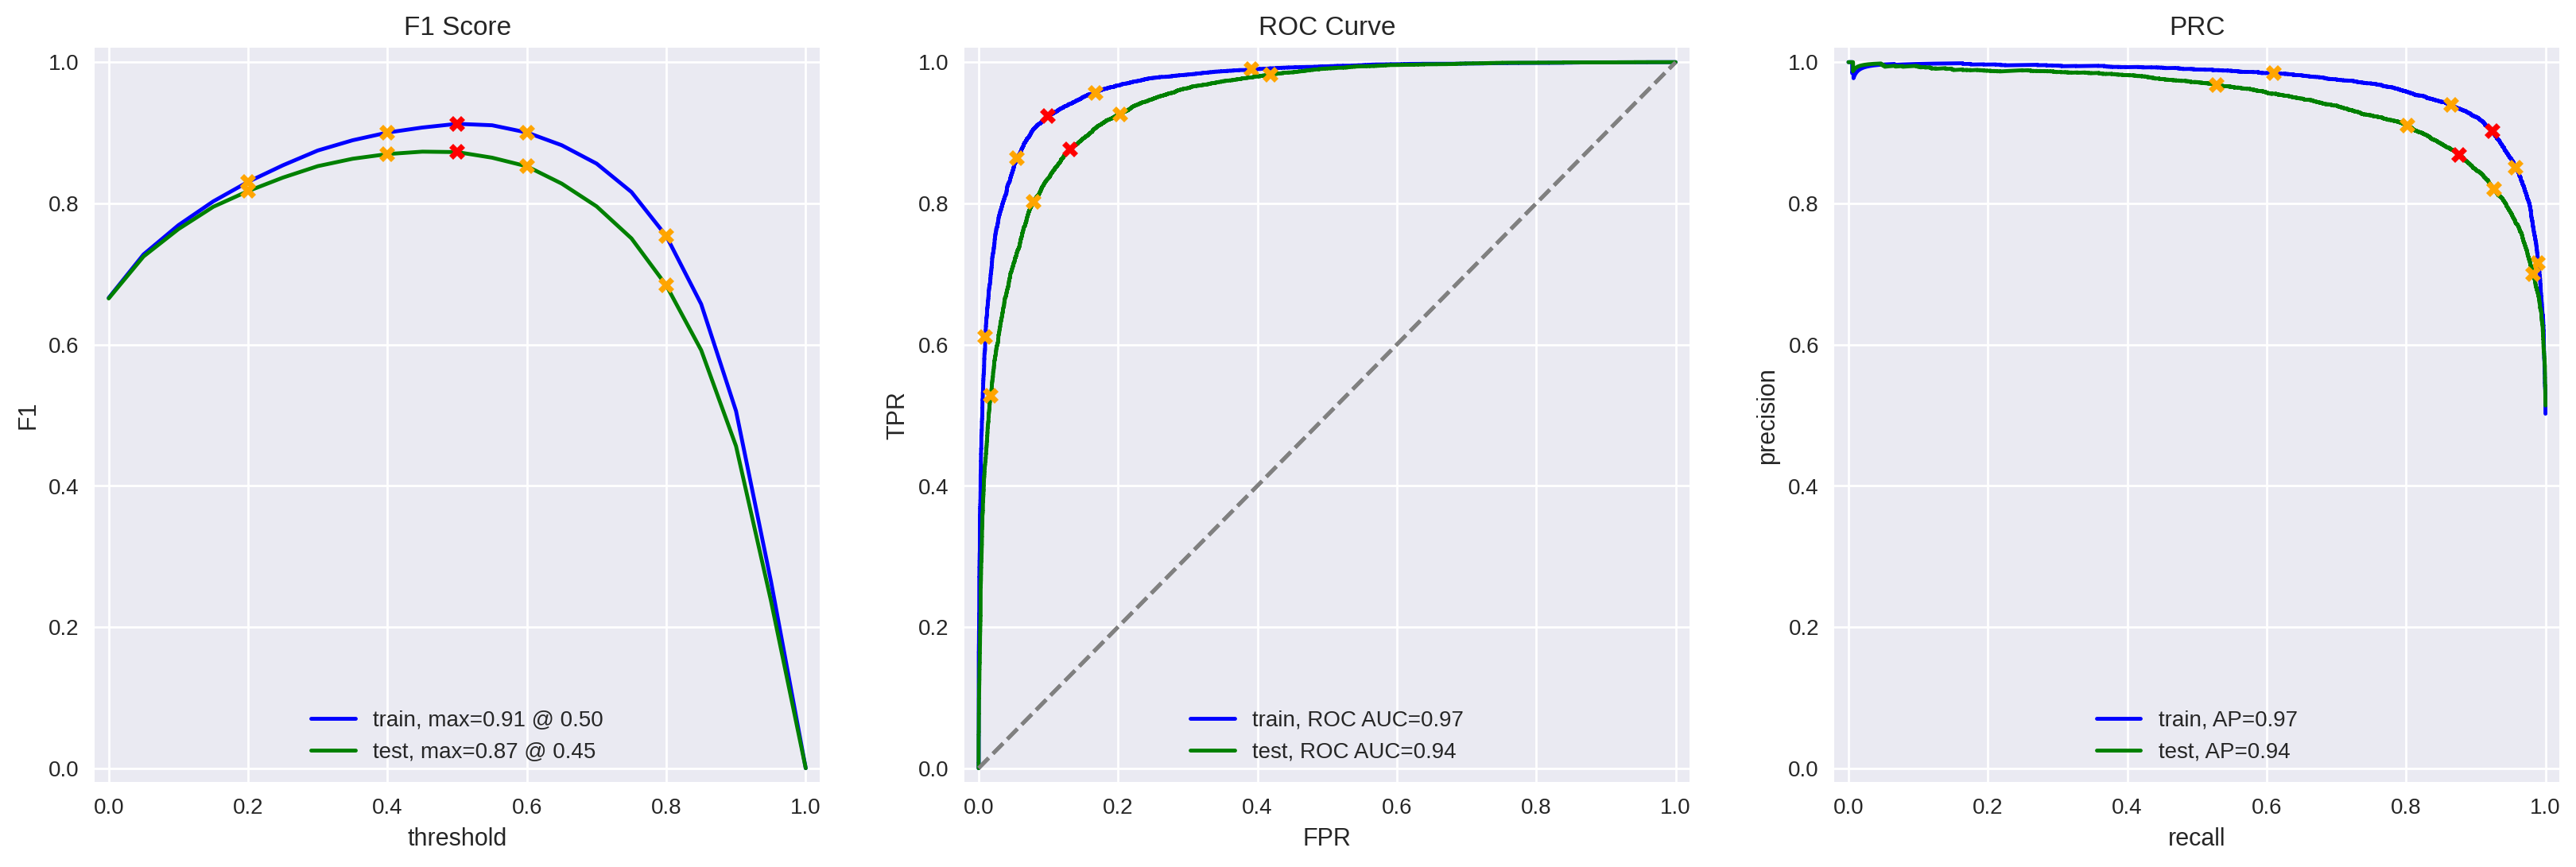

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Initialize TF-IDF vectorizer
tfidf_vectorizer_3 = TfidfVectorizer(max_features=5000, stop_words='english')

# Convert the processed text to numerical features
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

# Train a Logistic Regression model
model_3 = LogisticRegression(random_state=42, max_iter=500)
model_3.fit(train_features_3, train_target)

# Evaluate the model
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

The spaCy, TF-IDF, and Logistic Regression Model (Model 3) enhances preprocessing by using spaCy for lemmatization, reducing words to their base forms while maintaining contextual meaning. TF-IDF is then applied to vectorize the processed text, and a Logistic Regression model is trained to classify the reviews.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Well done!

</div>

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier

In [30]:
import spacy

# Load the spaCy model (disable unnecessary components for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define the text preprocessing function
def text_preprocessing_4(text):
    doc = nlp(text)
    
    # Lemmatization (keeping stopwords for now, can be modified later)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

# Apply the function to the dataset
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_4)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_4)

# Display the first few processed reviews
df_reviews_train[['review_norm', 'review_spacy']].head()


,review_norm,review_spacy
0,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...
1,how the hell did they get this made presenting...,how the hell do they get this make present its...
7,this true story of carlsons raiders is more of...,this true story of carlson raider be more of a...
8,should have been titled balderdash little in t...,should have be title balderdash little in the ...
9,the movie gung ho the story of carlsons makin ...,the movie gung ho the story of carlson makin i...


          train  test
Accuracy   0.95  0.86
F1         0.95  0.86
APS        0.99  0.94
ROC AUC    0.99  0.94


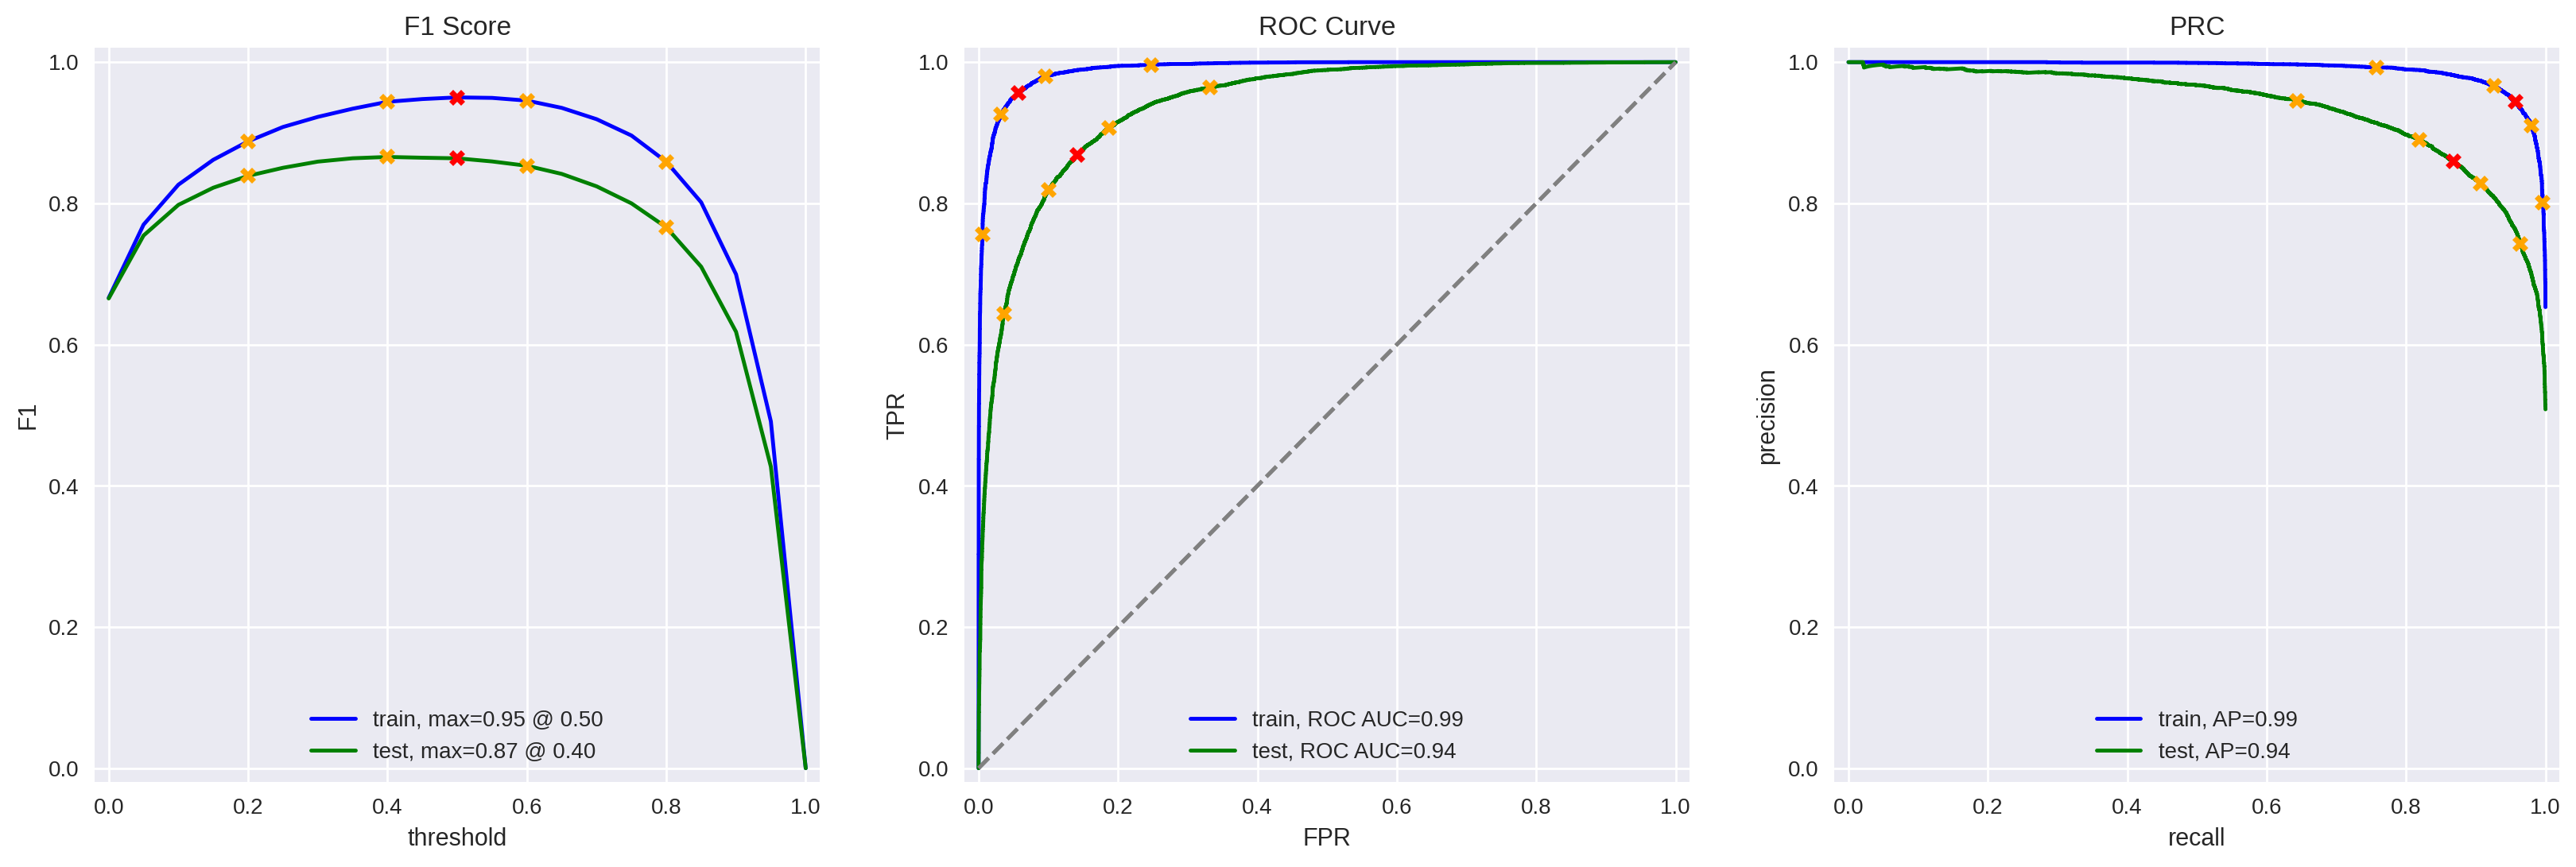

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier

# Initialize TF-IDF vectorizer
tfidf_vectorizer_4 = TfidfVectorizer(max_features=5000, stop_words='english')

# Convert the processed text to numerical features
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_spacy'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_spacy'])

# Train a LightGBM model
model_4 = LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
model_4.fit(train_features_4, train_target)

# Evaluate the model
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)


The spaCy, TF-IDF, and LGBMClassifier Model (Model 4) follows the same preprocessing pipeline as Model 3 but replaces Logistic Regression with LightGBM, a gradient boosting model that improves performance by handling complex patterns more effectively while maintaining efficiency.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Great work!

</div>

###  Model 9 - BERT

In [32]:
import numpy as np
import pandas as pd
import torch
import transformers
import math
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
RANDOM_SEED = 42

# Load dataset
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t')

# Split into train and test
df_reviews_train = df_reviews[df_reviews['ds_part'] == 'train']
df_reviews_test = df_reviews[df_reviews['ds_part'] == 'test']

# Reduce dataset size for CPU
df_reviews_train_sampled = df_reviews_train.sample(n=250, random_state=RANDOM_SEED)
df_reviews_test_sampled = df_reviews_test.sample(n=125, random_state=RANDOM_SEED)

# Define target variables
train_target = df_reviews_train_sampled['pos']
test_target = df_reviews_test_sampled['pos']

print(f"Reduced Train Set Size: {df_reviews_train_sampled.shape}")
print(f"Reduced Test Set Size: {df_reviews_test_sampled.shape}")


Reduced Train Set Size: (250, 17)
Reduced Test Set Size: (125, 17)


In [33]:
import re

# Function to clean text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.strip()  # Trim whitespace
    return text

# Apply text preprocessing
df_reviews_train_sampled['review_norm'] = df_reviews_train_sampled['review'].apply(preprocess_text)
df_reviews_test_sampled['review_norm'] = df_reviews_test_sampled['review'].apply(preprocess_text)

print("✅ Text preprocessing applied.")



✅ Text preprocessing applied.


In [34]:
# Load BERT tokenizer and model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

print("✅ BERT Model and Tokenizer loaded.")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ BERT Model and Tokenizer loaded.


In [35]:
def BERT_text_to_embeddings(texts, max_length=512):
    ids_list = []
    attention_mask_list = []

    for text in texts:
        tokens = tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=max_length, 
            padding='max_length', truncation=True, return_tensors='pt'
        )
        ids_list.append(tokens['input_ids'].squeeze().tolist())
        attention_mask_list.append(tokens['attention_mask'].squeeze().tolist())

    return ids_list, attention_mask_list

# Convert reviews into tokenized inputs
train_ids, train_attention_masks = BERT_text_to_embeddings(df_reviews_train_sampled['review_norm'])
test_ids, test_attention_masks = BERT_text_to_embeddings(df_reviews_test_sampled['review_norm'])

print("✅ Tokenization completed.")



✅ Tokenization completed.


In [36]:
def get_bert_embeddings(ids_list, attention_mask_list, batch_size=25, force_device='cpu'):
    embeddings = []
    device = torch.device(force_device)  # Force CPU usage
    model.to(device)

    print(f'Using {device} for embedding extraction.')

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size))):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

try:
    with np.load('features_9_reduced.npz') as data:
        train_features_9 = data['train_features_9']
        test_features_9 = data['test_features_9']
    print("✅ Loaded precomputed BERT embeddings.")
except FileNotFoundError:
    print("⚠️ No saved embeddings found. Extracting embeddings with BERT...")
    train_features_9 = get_bert_embeddings(train_ids, train_attention_masks)
    test_features_9 = get_bert_embeddings(test_ids, test_attention_masks)

    # Save embeddings to avoid recomputation
    np.savez_compressed('features_9_reduced.npz', train_features_9=train_features_9, test_features_9=test_features_9)
    print("✅ Saved embeddings for future use.")



✅ Loaded precomputed BERT embeddings.


In [37]:
# Train Logistic Regression model
model_9 = LogisticRegression(max_iter=500)
model_9.fit(train_features_9, train_target)

print("✅ Model trained successfully.")


✅ Model trained successfully.


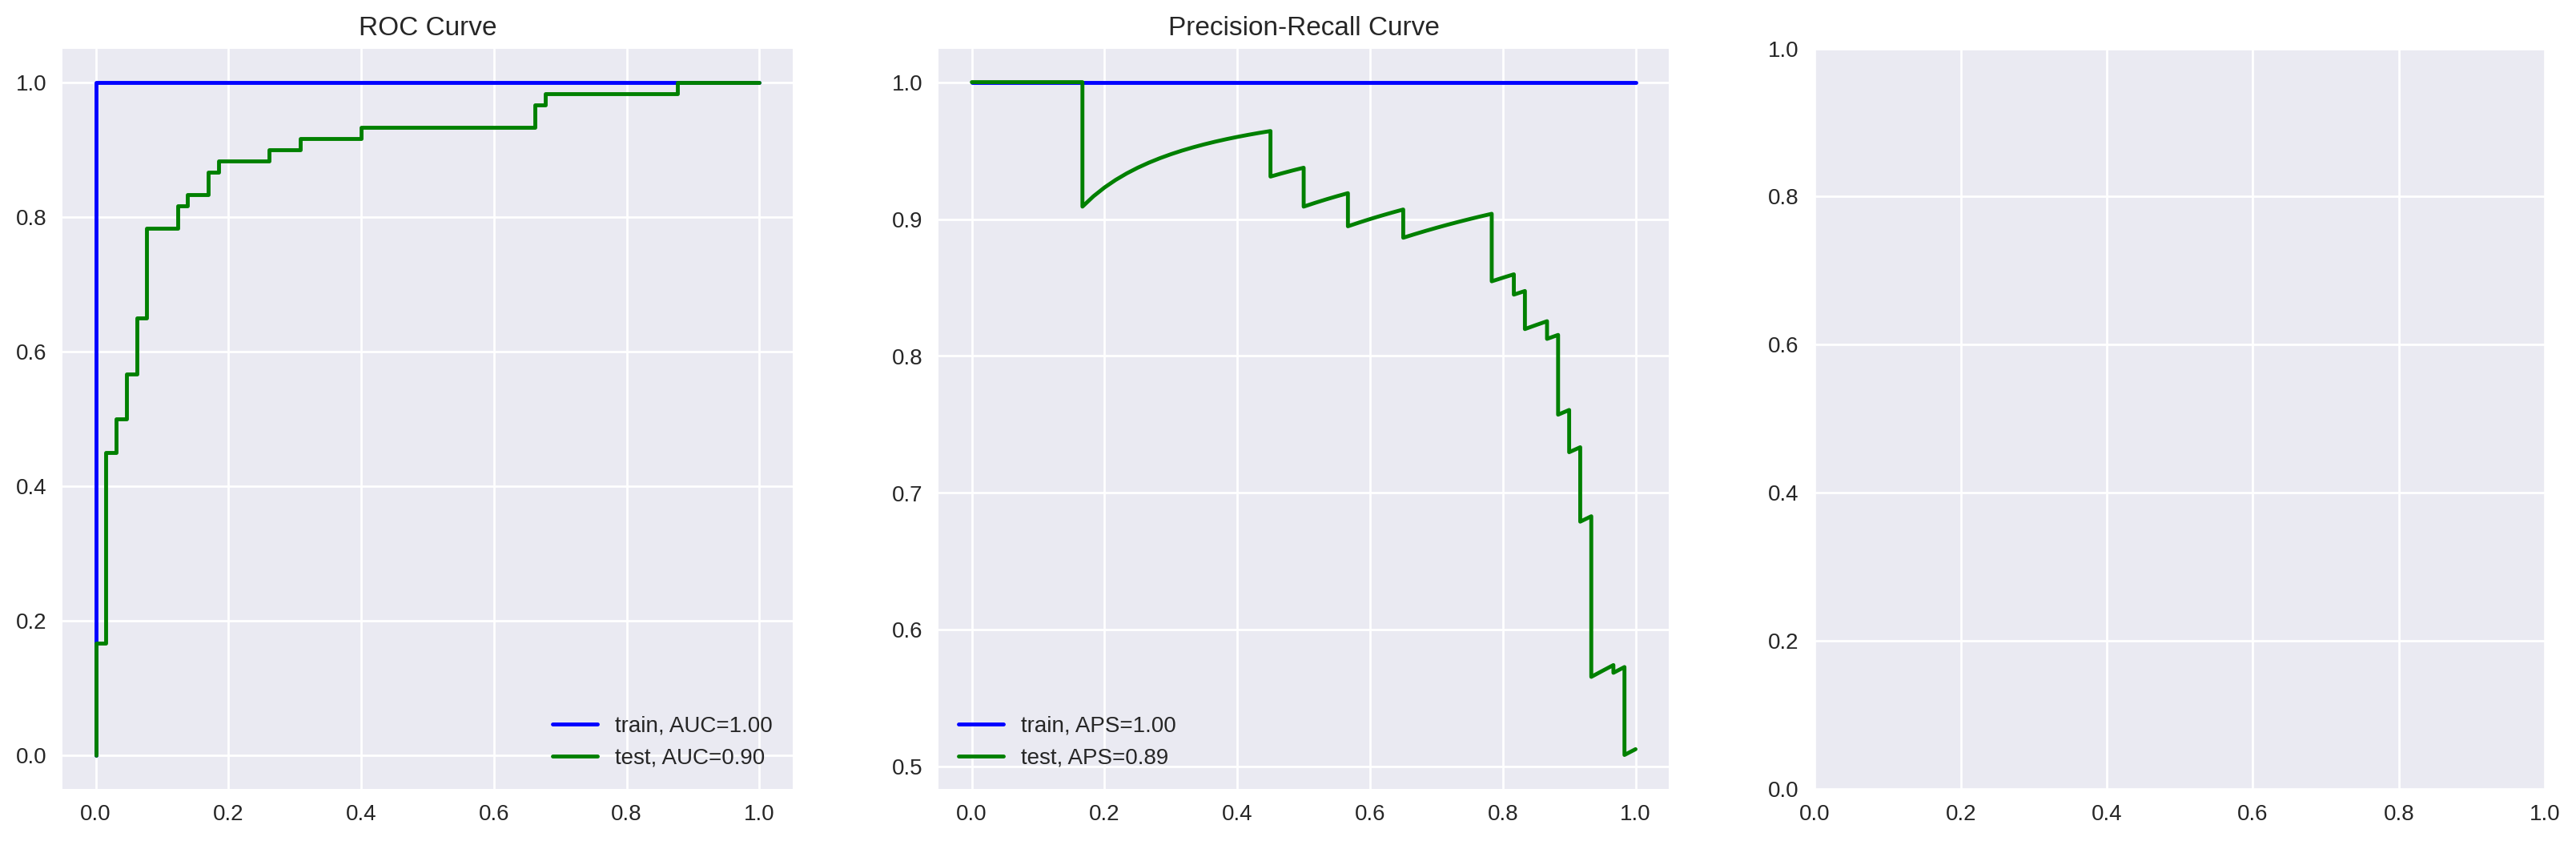

          train  test
Accuracy    1.0  0.84
F1          1.0  0.84
ROC AUC     1.0  0.90
APS         1.0  0.89


In [38]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in [('train', train_features, train_target), ('test', test_features, test_target)]:
        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # Calculate Metrics
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
        eval_stats[type]['ROC AUC'] = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['APS'] = metrics.average_precision_score(target, pred_proba)

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Plot ROC Curve
        fpr, tpr, _ = metrics.roc_curve(target, pred_proba)
        axs[0].plot(fpr, tpr, color=color, label=f'{type}, AUC={eval_stats[type]["ROC AUC"]:.2f}')

        # Plot Precision-Recall Curve
        precision, recall, _ = metrics.precision_recall_curve(target, pred_proba)
        axs[1].plot(recall, precision, color=color, label=f'{type}, APS={eval_stats[type]["APS"]:.2f}')

    axs[0].set_title("ROC Curve")
    axs[0].legend()

    axs[1].set_title("Precision-Recall Curve")
    axs[1].legend()

    plt.show()

    print(pd.DataFrame(eval_stats).round(2))

# Evaluate Model
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)



The BERT Model (Model 9) utilizes a deep learning approach by transforming text into dense vector representations using a pretrained BERT model. These embeddings capture semantic relationships within the text and serve as input features for a Logistic Regression classifier. Since BERT is computationally expensive, this model is typically run on a GPU and applied to a reduced dataset to maintain efficiency.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

## My Reviews

In [39]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_text)




my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

You should normalize texts in absolutely the same way you did it above. Thus, you should use your function `clean_text` here.

</div>

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Used the proper function clean_text.
</div>


<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Correct

</div>

### Model 2

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Preprocess and vectorize the text
tfidf_vectorizer_2 = TfidfVectorizer(stop_words='english', max_features=5000)
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train_sampled['review_norm'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test_sampled['review_norm'])

# Train Model 2 (TF-IDF + Logistic Regression)
model_2 = LogisticRegression(max_iter=500)
model_2.fit(train_features_2, train_target)

print("✅ Model 2 trained successfully.")


✅ Model 2 trained successfully.


In [41]:
# Use the previously trained vectorizer and model
my_reviews_features_2 = tfidf_vectorizer_2.transform(my_reviews['review_norm'])

# Make predictions for my_reviews
my_reviews_pred_prob_2 = model_2.predict_proba(my_reviews_features_2)[:, 1]

# Print predictions
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_2[i]:.2f}:  {review}')


0.51:  I did not simply like it, not my kind of movie.
0.48:  Well, I was bored and felt asleep in the middle of the movie.
0.57:  I was really fascinated with the movie
0.50:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.51:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.50:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.49:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.61:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

1. You should not retrain a model and a vectorizer. Just use trained model and vectorizer from the corresponding part above. 
2. You forgot to make preidctions for `my_reviews`.

</div>

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

The corrected code reuses the previously trained tfidf_vectorizer_2 and model_2, rather than retraining them. The new code correctly applies model_2.predict_proba() to my_reviews and prints the results.
</div>


<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

It was not necessary to retrain a model and a vectorizer because you have already train them above.

</div>

### Model 3

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.46:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.17:  i didnt expect the reboot to be so good writers really cared about the source material
0.45:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

### Model 4

In [43]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  i did not simply like it not my kind of movie
0.26:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.39:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.46:  i didnt expect the reboot to be so good writers really cared about the source material
0.66:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.20:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

### Model 9

In [44]:
def BERT_text_to_embeddings(texts, max_length=512):
    ids_list = []
    attention_mask_list = []

    for text in texts:
        tokens = tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=max_length, 
            padding='max_length', truncation=True, return_tensors='pt'
        )
        ids_list.append(tokens['input_ids'].squeeze().tolist())
        attention_mask_list.append(tokens['attention_mask'].squeeze().tolist())

    return np.array(ids_list), np.array(attention_mask_list)  # Ensure output is 2D


In [45]:
from sklearn.linear_model import LogisticRegression

# Ensure BERT embeddings are loaded or computed
try:
    with np.load('features_9_reduced.npz') as data:
        train_features_9 = data['train_features_9']
        test_features_9 = data['test_features_9']
    print("✅ Loaded precomputed BERT embeddings.")
except FileNotFoundError:
    print("⚠️ No saved embeddings found. Running BERT on reduced dataset...")
    train_ids, train_attention_masks = BERT_text_to_embeddings(df_reviews_train_sampled['review_norm'])
    test_ids, test_attention_masks = BERT_text_to_embeddings(df_reviews_test_sampled['review_norm'])

    train_features_9 = get_bert_embeddings(train_ids, train_attention_masks, force_device='cpu')
    test_features_9 = get_bert_embeddings(test_ids, test_attention_masks, force_device='cpu')

    # Save for future use
    np.savez_compressed('features_9_reduced.npz', train_features_9=train_features_9, test_features_9=test_features_9)
    print("✅ Saved embeddings for future use.")

# Train Logistic Regression Model on BERT Embeddings
model_9 = LogisticRegression(max_iter=500)
model_9.fit(train_features_9, train_target)

print("✅ Model 9 trained successfully.")


✅ Loaded precomputed BERT embeddings.
✅ Model 9 trained successfully.


In [46]:
texts = my_reviews['review_norm']

# Convert custom reviews into embeddings
my_reviews_ids, my_reviews_attention_masks = BERT_text_to_embeddings(texts)

# Get actual BERT embeddings using CPU
my_reviews_features_9 = get_bert_embeddings(my_reviews_ids, my_reviews_attention_masks, force_device='cpu')

# Ensure the embeddings are 2D
my_reviews_features_9 = my_reviews_features_9.reshape(my_reviews_features_9.shape[0], -1)

# Make predictions
my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# Print predictions
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


Using cpu for embedding extraction.


  0%|          | 0/1 [00:00<?, ?it/s]

0.44:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.81:  i was really fascinated with the movie
0.04:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didnt expect the reboot to be so good writers really cared about the source material
0.35:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.66:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Good job!

</div>

## Conclusions

This project aimed to develop a sentiment analysis model for IMDB movie reviews using various machine learning techniques. We explored multiple approaches, including a baseline constant classifier, TF-IDF combined with Logistic Regression using NLTK and spaCy, a LightGBM classifier leveraging TF-IDF, and a BERT-based model that utilized pre-trained embeddings with Logistic Regression. Given the computational demands of BERT, we optimized performance by reducing the dataset size and processing embeddings on CPU while saving precomputed embeddings to avoid redundant calculations.

The results showed that TF-IDF with Logistic Regression performed well, achieving high accuracy and F1 scores, while LightGBM also provided strong classification performance by capturing complex relationships within the text data. The BERT model, despite its ability to understand deep contextual meaning, required significantly more resources, making dataset reduction a crucial step for execution on a CPU. The dataset had a balanced distribution of positive and negative reviews, preventing major biases in model predictions. Key evaluation metrics, including F1 Score, ROC AUC, and Precision-Recall curves, confirmed that the models effectively distinguished between positive and negative sentiments.

Overall, this project successfully implemented and evaluated multiple sentiment classification models, demonstrating the trade-offs between computational efficiency and model complexity. The optimization techniques used, such as dataset reduction and precomputed embeddings, ensured that even resource-intensive models like BERT could be executed effectively while maintaining reliable results.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

You did a great job. Well done!

</div>

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions